In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../RD-systems-and-test-benches/utils")
import model_fsolve as modf

import scipy.optimize as sco
import scipy.interpolate as sci

import simu as sim

import hx_hydraulic as hxhy
import from_excel as fe
import data_plots as dplt

import fluids as fds
from CoolProp.CoolProp import PropsSI

import openpyxl as opxl
from sklearn.ensemble import RandomForestRegressor

In [11]:
def Triple_PL(Q, water):
    if water :
        rho = 1000
        eta = 1e-3
    else :
        rho = PropsSI('D','P',101325,'T',293.15,'INCOMP::MEG[0.4]')
        eta = PropsSI('V','P',101325,'T',293.15,'INCOMP::MEG[0.4]')
    ep = 1e-3

    Dx = 10e-3

    Lx = 24.97
    R = 35e-3
    Ax = np.pi*(Dx/2)**2
    ux = Q/Ax

    # Pertes régulières
    Rex = fds.core.Reynolds(ux,Dx,rho,mu=eta)
    fx = fds.friction.friction_factor(Rex,eD=ep/Dx)
    ax_RPL = fx*(Lx/Dx)

    # Pertes singulières
    K_R = fds.fittings.bend_rounded(Dx, 180, rc=R, method='Crane')
    K_r = fds.fittings.bend_rounded(Dx, 180, rc=R/2, method='Crane')
    K_90 = fds.fittings.bend_rounded(Dx, 90, rc=R, method='Crane')
    ax_SPL = (20*K_R + 2*K_r + 4*K_90)

    return (ax_RPL+ax_SPL)*rho*ux**2/2, fx, Rex

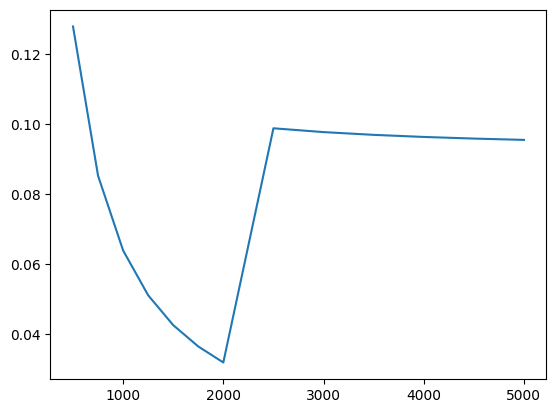

In [12]:
Re_list = np.array([500,750,1000,1250,1500,1750,2000,2500,3000,3500,4000,4500,5000])
f_list = [fds.friction.friction_factor(Re,eD=1e-3/12e-3) for Re in Re_list]
plt.plot(Re_list,f_list)
plt.show()

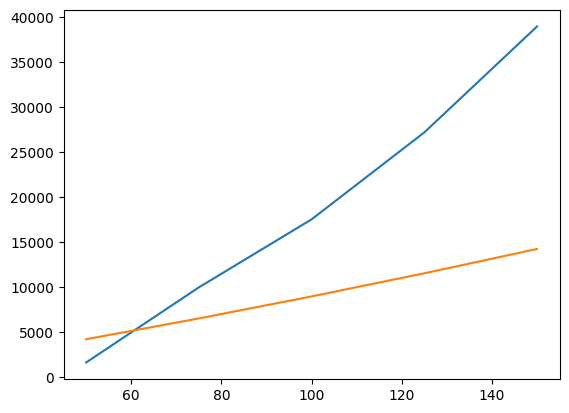

In [13]:
Q_list = np.array([50,75,100,125,150])/3600000
PL_list = [Triple_PL(Q, True)[0] for Q in Q_list]
PL_list2 = [Triple_PL(Q, False)[0] for Q in Q_list]
plt.plot(Q_list*3600000,PL_list)
plt.plot(Q_list*3600000,PL_list2)
plt.show()

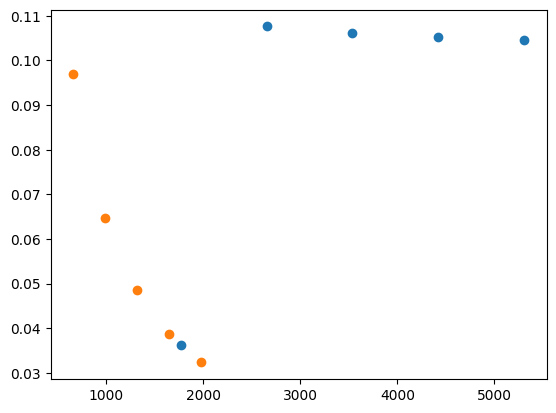

In [14]:
f_list = [Triple_PL(Q, True)[1] for Q in Q_list]
f_list2 = [Triple_PL(Q, False)[1] for Q in Q_list]
Re_list = [Triple_PL(Q, True)[2] for Q in Q_list]
Re_list2 = [Triple_PL(Q, False)[2] for Q in Q_list]
plt.scatter(Re_list,f_list)
plt.scatter(Re_list2,f_list2)
plt.show()

In [1]:
path = r"G:\Drive partagés\BU04-Innovation\PVT-PL-model\Inputs"
file_name = "\Triple_Solar_x4.xlsx"

In [4]:
hw, par, cond = fe.initialize(path, file_name)
par["sch"]="Triple"
tabl, res, PL, testings, fun = modf.PL_fsolve(par, cond)

NameError: name 'fe' is not defined

In [17]:
tabl

,Pin,Pout,qx
0,7174.513927,3.246390e+02,100.565151
1,6993.182566,2.668834e+02,99.490863
2,6925.447826,1.589983e+02,99.632822
3,6877.353218,5.605649e-23,100.311163


In [18]:
tabl["qx"]/tabl["qx"].mean()

0    1.005652
1    0.994909
2    0.996328
3    1.003112
Name: qx, dtype: float64